In [1]:
from sklearn.datasets import fetch_openml
import numpy as np
import time
import torch
from scipy.optimize import linprog
from qpsolvers import solve_qp
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator
from torch.autograd import Function
import torch.nn as nn
from sklearn.model_selection import train_test_split
import sys
#import StochasticGhost
import importlib
from torch.nn.utils import clip_grad_norm_
import pandas as pd
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import ..Ghost
import torch.nn.functional as F

In [2]:
SENSITIVE_CODE_1 = 1
SENSITIVE_CODE_0 = 0

raw_data = pd.read_csv("compas-scores-two-years.csv")

df = raw_data[['age', 'c_charge_degree', 'race', 'age_cat', 'score_text', 'sex', 'priors_count',
               'days_b_screening_arrest', 'decile_score', 'is_recid', 'two_year_recid', 'c_jail_in', 'c_jail_out']]
df = df[(df['days_b_screening_arrest'] <= 30) & (df['days_b_screening_arrest'] >= -30) &
        (df['is_recid'] != -1) & (df['c_charge_degree'] != "O") & (df['score_text'] != 'N/A')]

df['length_of_stay'] = pd.to_datetime(
    df['c_jail_out']) - pd.to_datetime(df['c_jail_in'])
df['length_of_stay'] = df['length_of_stay'].dt.total_seconds() / 3600

df_needed = df[(df['race'] == 'Caucasian') | (df['race'] == 'African-American')]
race_mapping = {'African-American': SENSITIVE_CODE_1, 'Caucasian': SENSITIVE_CODE_0}

# Create a new column 'race_code' based on the mapping
df_needed['race_code'] = df_needed['race'].map(race_mapping)


/tmp/ipykernel_255671/802406756.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_needed['race_code'] = df_needed['race'].map(race_mapping)


In [3]:
# Categorizing
df_needed['crime_code'] = pd.Categorical(df_needed['c_charge_degree']).codes
df_needed['age_code'] = pd.Categorical(df_needed['age_cat']).codes
df_needed['race_code'] = df_needed['race'].map(race_mapping)
df_needed['gender_code'] = pd.Categorical(df_needed['sex']).codes
df_needed['score_code'] = pd.Categorical(df_needed['score_text']).codes
df_needed['charge_degree_code'] = pd.Categorical(
    df_needed['c_charge_degree']).codes


/tmp/ipykernel_255671/1847072954.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_needed['crime_code'] = pd.Categorical(df_needed['c_charge_degree']).codes
/tmp/ipykernel_255671/1847072954.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_needed['age_code'] = pd.Categorical(df_needed['age_cat']).codes
/tmp/ipykernel_255671/1847072954.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

In [4]:
##### Uncomment this code block if you want to make analysis over all the attributes #####
in_df = df_needed[['priors_count', 'score_code', 'age_code', 'gender_code', 'race_code', 'crime_code', 'charge_degree_code']]
out_df = df_needed[['two_year_recid']]

RACE_IND = 4

In [5]:
#in_df = df_needed[['priors_count', 'race_code']]
#out_df = df_needed[['two_year_recid']]

#RACE_IND = 1

In [6]:
blacks_in = len(df_needed[(df_needed['race_code'] == SENSITIVE_CODE_1) & (df_needed['two_year_recid']== 0)])
whites_in = len(df_needed[(df_needed['race_code'] == SENSITIVE_CODE_0) & (df_needed['two_year_recid'] == 0)])
print(blacks_in, whites_in)

1514 1281


In [7]:
class CustomNetwork(nn.Module):

    # For now the input data is passed as init parameters
    def __init__(self, layer_sizes, itrain, otrain, ival, oval, itrain_raw):
        super(CustomNetwork, self).__init__()

        # Create a list of linear layers based on layer_sizes
        self.itrain = itrain
        self.otrain = otrain
        self.ival = ival
        self.oval = oval
        self.itrain_raw = itrain_raw
        self.layers = nn.ModuleList()
        self.layer_norms = nn.ModuleList()
        for i in range(len(layer_sizes) - 1):
            self.layers.append(nn.Linear(layer_sizes[i], layer_sizes[i+1]))

    def forward(self, x):
        for layer in self.layers[:-1]:
            x = torch.relu((layer(x)))
        x = torch.sigmoid(self.layers[-1](x))
        return x
    

    ######Only this loss function is used here######
    def compute_loss(self, Y, Y_hat):
        L_sum = 0.5*torch.sum(torch.square(Y - Y_hat))

        m = Y.shape[0]
        # print("Y shape is: ", m)
        L = (1./m) * L_sum

        return L

    def bce_loss(self, outputs, targets):
        criterion = nn.BCELoss()
        loss = criterion(outputs, targets)
        if torch.isnan(loss).any():
            for name, param in self.named_parameters():
                print(name)
                print(param.data)
        return loss

    def obj_fun(self, params, minibatch):
        model_parameters = list(self.parameters())
        x = self.itrain
        y = self.otrain
        #x_blacks = x[:, ]
        samples = np.random.choice(len(y), minibatch, replace=False)
        for i in range(len(params)):
            model_parameters[i].data = torch.Tensor(params[i])

        #print("LOOKIE:",x[samples, :])
        obj_fwd = self.forward(x[samples, :]).flatten()
        if torch.isnan(obj_fwd).any():
            for name, param in self.named_parameters():
                print(name)
                print(param.data)
        #print("LOOKIE the predicted values: ",obj_fwd)
        #print(obj_fwd.shape)
        #print("LOOKIE the actual values: ",y[samples].flatten())
        fval = self.compute_loss(obj_fwd, y[samples].flatten())
        print("Training loss is: ", fval)
        return fval.item()

    def obj_grad(self, params, minibatch):
        fgrad = []
        x = self.itrain
        y = self.otrain
        samples = np.random.choice(len(y), minibatch, replace=False)
        obj_fwd = self.forward(x[samples, :]).flatten()
        obj_loss = self.compute_loss(obj_fwd, y[samples].flatten())
        obj_loss.backward()

        #max_norm = 0.5
        #clip_grad_norm_(self.parameters(), max_norm)
        for param in self.parameters():
            if param.grad is not None:
                # Clone to avoid modifying the original tensor
                fgrad.append(param.grad.data.clone().view(-1))

        # Manually set gradients to zero
        for param in self.parameters():
            if param.grad is not None:
                param.grad.data.zero_()

        fgrad = torch.cat(fgrad, dim=0)
        return fgrad
    
    def constraint_loss(self, dist1, dist2):
        sum = 0
        for i in range(len(dist1)):
            sum = sum + dist1[i]*torch.log(dist1[i]/dist2[i])
        return sum
    
    def jensen_shannon_divergence(self, p, q):
        m = 0.5 * (p + q)
        kl_div_p_m = F.kl_div(p.log(), m, reduction='batchmean')
        kl_div_q_m = F.kl_div(q.log(), m, reduction='batchmean')
        return 0.5 * (kl_div_p_m + kl_div_q_m)

    def get_cov(self, f_val, a):
        #print("Calculating Cov:")
        #print(len(f_val))
        #print(len(a))
        a_avg = torch.mean(a)
        sum = 0
        for i in range(len(a)):
           sum = sum + (a[i]-a_avg)*f_val[i]
        print("Covariance between Pred and race label is: ", sum**2)
        return sum**2


    def conf(self, params, minibatch):
        #print("Reached at function constraint")
        conf_val = None
        x_train = self.itrain
        y_train = self.otrain
        x_train_raw = self.itrain_raw
        x_blacks = x_train[(x_train_raw[:, RACE_IND] == SENSITIVE_CODE_1), :]
        y_blacks = y_train[(x_train_raw[:, RACE_IND] == SENSITIVE_CODE_1)]
        x_whites = x_train[(x_train_raw[:, RACE_IND] == SENSITIVE_CODE_0), :]
        y_whites = y_train[(x_train_raw[:, RACE_IND] == SENSITIVE_CODE_0)]
        
        # print("Total no of whites with y=0=", x_whites_0_lab.shape[0])
        black_samples = np.random.choice(len(y_blacks), minibatch, replace=False)
        white_samples = np.random.choice(len(y_whites), minibatch, replace=False)
        #samples = np.random.choice(len(y_val), minibatch, replace=False)
        #conf_val = self.forward(x_val[minibatch, :])
        cons_fwd_black = self.forward(x_blacks[black_samples, :]).flatten()
        cons_loss_black = self.compute_loss(cons_fwd_black, y_train[black_samples].flatten())

        cons_fwd_white = self.forward(x_whites[white_samples, :]).flatten()
        cons_loss_white = self.compute_loss(cons_fwd_white, y_train[white_samples].flatten())

        cons_loss = (cons_loss_black - cons_loss_white)**2
        #cons_loss = cons_loss_black
        print("Avg Loss over black samples: ", cons_loss_black)
        print("Avg Loss over white samples: ", cons_loss_white)
        print("Validation loss is: ", cons_loss)
        return (cons_loss.item())
    
    def conJ(self, params, minibatch):
        #print("Reached at function constraint grad")
        cgrad = []
        x_train = self.itrain
        y_train = self.otrain
        x_train_raw = self.itrain_raw
        x_blacks = x_train[(x_train_raw[:, RACE_IND] == SENSITIVE_CODE_1), :]
        y_blacks = y_train[(x_train_raw[:, RACE_IND] == SENSITIVE_CODE_1)]
        x_whites = x_train[(x_train_raw[:, RACE_IND] == SENSITIVE_CODE_0), :]
        y_whites = y_train[(x_train_raw[:, RACE_IND] == SENSITIVE_CODE_0)]

        black_samples = np.random.choice(len(y_blacks), minibatch, replace=False)
        white_samples = np.random.choice(len(y_whites), minibatch, replace=False)
        # samples = np.random.choice(len(y_val), minibatch, replace=False)
        # conf_val = self.forward(x_val[minibatch, :])
        cons_fwd_black = self.forward(x_blacks[black_samples, :]).flatten()
        cons_loss_black = self.compute_loss(cons_fwd_black, y_train[black_samples].flatten())

        cons_fwd_white = self.forward(x_whites[white_samples, :]).flatten()
        cons_loss_white = self.compute_loss(cons_fwd_white, y_train[white_samples].flatten())
        #cons_loss = cons_loss_black
        cons_loss = (cons_loss_black - cons_loss_white)**2
        cons_loss.backward()
        #max_norm = 0.5
        #clip_grad_norm_(self.parameters(), max_norm)
        for param in self.parameters():
            if param.grad is not None:
                cgrad.append(param.grad.data.clone().view(-1))  # Clone to avoid modifying the original tensor

# Manually set gradients to zero without using optimizer.zero_grad()
        for param in self.parameters():
            if param.grad is not None:
                param.grad.data.zero_()

        
        cgrad = torch.cat(cgrad, dim=0)
        
        return cgrad

In [8]:
def paramvals(maxiter, beta, rho, lamb, hess, tau, mbsz, numcon, geomp, stepdecay, gammazero, zeta, N, n, lossbound, scalef):
    params = {
        'maxiter': maxiter,  # number of iterations performed
        'beta': beta,  # trust region size
        'rho': rho,  # trust region for feasibility subproblem
        'lamb': lamb,  # weight on the subfeasibility relaxation
        'hess': hess,  # method of computing the Hessian of the QP, options include 'diag' 'lbfgs' 'fisher' 'adamdiag' 'adagraddiag'
        'tau': tau,  # parameter for the hessian
        'mbsz': mbsz,  # the standard minibatch size, used for evaluating the progress of the objective and constraint
        'numcon': numcon,  # number of constraint functions
        'geomp': geomp,  # parameter for the geometric random variable defining the number of subproblem samples
        # strategy for step decrease, options include 'dimin' 'stepwise' 'slowdimin' 'constant'
        'stepdecay': stepdecay,
        'gammazero': gammazero,  # initial stepsize
        'zeta': zeta,  # parameter associated with the stepsize iteration
        'N': N,  # Train/val sample size
        'n': n,  # Total number of parameters
        'lossbound': lossbound, #Bound on constraint loss
        'scalef': scalef #Scaling factor for constraints
    }
    return params

In [9]:
######Training loop######
trials = 21
maxiter = 500
acc_arr = []
max_acc = 0
ftrial = np.zeros((maxiter, trials))
ctrial1 = np.zeros((maxiter, trials))
ctrial2 = np.zeros((maxiter, trials))
initsaved = []
x_train, x_val, y_train, y_val = train_test_split(in_df.values, out_df.values, test_size=0.3, random_state=42)
ip_size = x_train.shape[1]
scaler = StandardScaler()
X_train = scaler.fit_transform(x_train)
X_val = scaler.transform(x_val)
X_train = torch.tensor(X_train, dtype=torch.float32)
Y_train = torch.tensor(y_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
Y_val = torch.tensor(y_val, dtype=torch.float32)
saved_model = []
TPR_black = np.zeros(trials)
TPR_white = np.zeros(trials)
FPR_black = np.zeros(trials)
FPR_white = np.zeros(trials)
TNR_black = np.zeros(trials)
FNR_black = np.zeros(trials)
TNR_white = np.zeros(trials)
FNR_white = np.zeros(trials)
for trial in range(trials):
    print(">>>>>>>>>>>>>>>>>>>>>>>>>>>>TRIAL", trial)
    
    #print(type(X_train))
    hid_size1 = 16
    hid_size2 = 16
    op_size = 1
    #print(X_val.shape)
    #print(Y_val.shape)
    layer_sizes = [ip_size, hid_size1, hid_size2, op_size]
    
    #x_len = x_train[:, 4]
    num_trials = min(len(y_train[((x_train[:, RACE_IND]) == SENSITIVE_CODE_1)]), len(y_train[(x_train[:, RACE_IND] == SENSITIVE_CODE_0)]))

    #num_trials = min(len(y_val[((x_val[:, 1]) == 0)]), len(y_val[(x_val[:, 1] == 1)]))
    #num_trials = min((y_train.reshape(-1) == 0)]), len(y_train[(x_len == 1) & (y_train.reshape(-1) == 0)]))
    #num_trials = len(y_val[(y_val.reshape(-1) == 1)])
    print(num_trials)
    #print(num_trials)
    net = CustomNetwork(
        layer_sizes, X_train[:, :ip_size], Y_train, X_val[:, :ip_size], Y_val, torch.tensor(x_train))
    #print(net)
    # net.apply(net.init_weights)
    nn_parameters = list(net.parameters())
    # print(net)
    initw = [param.data for param in nn_parameters]
    # print(len(initw))
    num_param = sum(p.numel() for p in net.parameters())
    params = paramvals(maxiter=maxiter, beta=10., rho=1e-4, lamb=0.5, hess='diag', tau=6., mbsz=100,
                       numcon=1, geomp=0.2, stepdecay='dimin', gammazero=0.1, zeta=0.1, N=num_trials, n=num_param, lossbound=[1e-5], scalef=[5.])
    w, iterfs, itercs = Ghost.StochasticGhost(
        net.obj_fun, net.obj_grad, [net.conf], [net.conJ], initw, params)
    ftrial[:, trial] = iterfs
    #print("The moment of TRUTH",itercs.shape)
    ctrial1[:, trial] = itercs[:,0]

    outputs = net.forward(X_val)
    predictions = (outputs >= 0.5).float()
    true = Y_val
    print(predictions.flatten())
    print(Y_val.flatten())
    acc = len(np.where(predictions.flatten() == Y_val.flatten())[0]) / len(Y_val.flatten())
    TP_black = len(np.where((x_val[:, RACE_IND] == SENSITIVE_CODE_1) & (np.array(predictions.flatten()).astype(int) == 1) & (y_val.flatten()==1))[0])
    FN_black = len(np.where((x_val[:, RACE_IND] == SENSITIVE_CODE_1) & (np.array(predictions.flatten()).astype(int) == 0) & (y_val.flatten()==1))[0])

    FP_black = len(np.where((x_val[:, RACE_IND] == SENSITIVE_CODE_1) & (np.array(predictions.flatten()).astype(int) == 1) & (y_val.flatten()==0))[0])
    TN_black = len(np.where((x_val[:, RACE_IND] == SENSITIVE_CODE_1) & (np.array(predictions.flatten()).astype(int) == 0) & (y_val.flatten()==0))[0])
    TPR_black[trial] = TP_black/(TP_black + FN_black)
    FPR_black[trial] = FP_black/(FP_black + TN_black)
    TNR_black[trial] = TN_black/(TN_black + FP_black)
    FNR_black[trial] = FN_black/(FN_black + TP_black)

    TP_white = len(np.where((x_val[:, RACE_IND] == SENSITIVE_CODE_0) & (np.array(predictions.flatten()).astype(int) == 1) & (y_val.flatten() == 1))[0])
    FN_white = len(np.where((x_val[:, RACE_IND] == SENSITIVE_CODE_0) & (np.array(predictions.flatten()).astype(int) == 0) & (y_val.flatten() == 1))[0])

    FP_white = len(np.where((x_val[:, RACE_IND] == SENSITIVE_CODE_0) & (np.array(predictions.flatten()).astype(int) == 1) & (y_val.flatten() == 0))[0])
    TN_white = len(np.where((x_val[:, RACE_IND] == SENSITIVE_CODE_0) & (np.array(predictions.flatten()).astype(int) == 0) & (y_val.flatten() == 0))[0])
    TPR_white[trial] = TP_white/(TP_white + FN_white)
    FPR_white[trial] = FP_white/(FP_white + TN_white)
    TNR_white[trial] = TN_white/(TN_white + FP_white)
    FNR_white[trial] = FN_white/(FN_white + TP_white)
    saved_model.append(net)
    acc_arr.append(acc)

>>>>>>>>>>>>>>>>>>>>>>>>>>>>TRIAL 0
1485
Training loss is:  tensor(0.1252, grad_fn=<MulBackward0>)
Avg Loss over black samples:  tensor(0.1262, grad_fn=<MulBackward0>)
Avg Loss over white samples:  tensor(0.1236, grad_fn=<MulBackward0>)
Validation loss is:  tensor(6.8531e-06, grad_fn=<PowBackward0>)
Training loss is:  tensor(0.1273, grad_fn=<MulBackward0>)
<class 'numpy.ndarray'>
Avg Loss over black samples:  tensor(0.1266, grad_fn=<MulBackward0>)
Avg Loss over white samples:  tensor(0.1269, grad_fn=<MulBackward0>)
Validation loss is:  tensor(7.7705e-08, grad_fn=<PowBackward0>)
<class 'numpy.ndarray'>
Training loss is:  tensor(0.1279, grad_fn=<MulBackward0>)
Avg Loss over black samples:  tensor(0.1267, grad_fn=<MulBackward0>)
Avg Loss over white samples:  tensor(0.1234, grad_fn=<MulBackward0>)
Validation loss is:  tensor(1.1421e-05, grad_fn=<PowBackward0>)
Training loss is:  tensor(0.1275, grad_fn=<MulBackward0>)
<class 'numpy.ndarray'>


/home/choudhar/anaconda3/envs/ghost/lib/python3.10/site-packages/qpsolvers/conversions/ensure_sparse_matrices.py:24: UserWarning: Converted P to scipy.sparse.csc.csc_matrix
For best performance, build P as a scipy.sparse.csc_matrix rather than as a numpy.ndarray
  warnings.warn(
/home/choudhar/anaconda3/envs/ghost/lib/python3.10/site-packages/qpsolvers/conversions/ensure_sparse_matrices.py:24: UserWarning: Converted G to scipy.sparse.csc.csc_matrix
For best performance, build G as a scipy.sparse.csc_matrix rather than as a numpy.ndarray
  warnings.warn(
/home/choudhar/anaconda3/envs/ghost/lib/python3.10/site-packages/qpsolvers/conversions/ensure_sparse_matrices.py:24: UserWarning: Converted A to scipy.sparse.csc.csc_matrix
For best performance, build A as a scipy.sparse.csc_matrix rather than as a numpy.ndarray
  warnings.warn(


Avg Loss over black samples:  tensor(0.1262, grad_fn=<MulBackward0>)
Avg Loss over white samples:  tensor(0.1269, grad_fn=<MulBackward0>)
Validation loss is:  tensor(4.9569e-07, grad_fn=<PowBackward0>)
<class 'numpy.ndarray'>
Training loss is:  tensor(0.1254, grad_fn=<MulBackward0>)
Avg Loss over black samples:  tensor(0.1232, grad_fn=<MulBackward0>)
Avg Loss over white samples:  tensor(0.1256, grad_fn=<MulBackward0>)
Validation loss is:  tensor(6.0250e-06, grad_fn=<PowBackward0>)
Training loss is:  tensor(0.1275, grad_fn=<MulBackward0>)
<class 'numpy.ndarray'>
Avg Loss over black samples:  tensor(0.1263, grad_fn=<MulBackward0>)
Avg Loss over white samples:  tensor(0.1269, grad_fn=<MulBackward0>)
Validation loss is:  tensor(3.2551e-07, grad_fn=<PowBackward0>)
<class 'numpy.ndarray'>
Training loss is:  tensor(0.1277, grad_fn=<MulBackward0>)
Avg Loss over black samples:  tensor(0.1257, grad_fn=<MulBackward0>)
Avg Loss over white samples:  tensor(0.1320, grad_fn=<MulBackward0>)
Validation

In [ ]:
df_out = pd.DataFrame(np.array(x_val), columns=[
                      'priors_count', 'score_code', 'age_code', 'gender_code', 'race_code', 'crime_code', 'charge_degree_code'])
df_out["pred_labels"] = np.array(predictions).astype(int)
df_out["true_labels"] = np.array(true).astype(int)

In [10]:
print(acc_arr)

[0.4438131313131313, 0.5359848484848485, 0.4053030303030303, 0.5315656565656566, 0.5612373737373737]


torch.Size([618, 7])
torch.Size([966, 7])


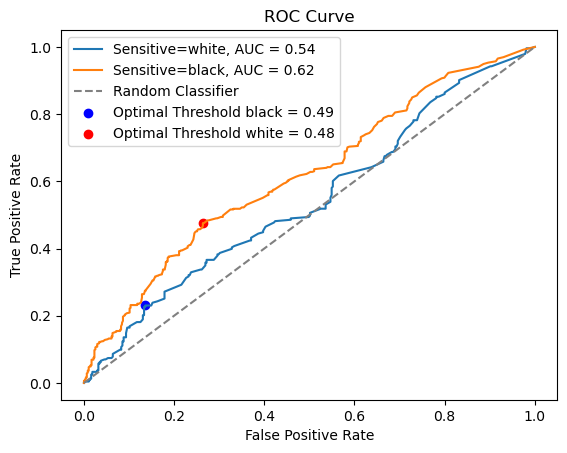

In [15]:
from sklearn.metrics import roc_curve, auc

# Load the best trail/trials
model = saved_model[4]


# Function to generate predictions and plot ROC curve
def plot_roc_curve(predictions, targets, sensitive_value):
    # Convert PyTorch tensors to numpy arrays
    predictions = predictions.detach().numpy()
    targets = targets.numpy()

    # Compute ROC curve and area under the curve
    fpr, tpr, thresholds = roc_curve(targets, predictions)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.plot(fpr, tpr, label=f'Sensitive={sensitive_value}, AUC = {roc_auc:.2f}')

    tpr_minus_fpr = tpr - fpr

    # Find the threshold that maximizes TPR - FPR difference
    optimal_threshold_index = np.argmax(tpr_minus_fpr)
    optimal_threshold = thresholds[optimal_threshold_index]

    # Plot the optimal threshold point on the ROC curve
    if sensitive_value=='black':
        plt.scatter(fpr[optimal_threshold_index], tpr[optimal_threshold_index], c='red', marker='o', label=f'Optimal Threshold white = {optimal_threshold:.2f}')
    if sensitive_value=='white':
        plt.scatter(fpr[optimal_threshold_index], tpr[optimal_threshold_index], c='blue', marker='o', label=f'Optimal Threshold black = {optimal_threshold:.2f}')

# Set your model to evaluation mode
model.eval()

# Forward pass for subgroup with sensitive attribute A=0
with torch.no_grad():
    print(X_val[(x_val[:, RACE_IND] == SENSITIVE_CODE_0), :].shape)
    predictions_0 = model(torch.Tensor(X_val[(x_val[:, RACE_IND] == SENSITIVE_CODE_0), :]))

# Forward pass for subgroup with sensitive attribute A=1
with torch.no_grad():
    print(X_val[(x_val[:, RACE_IND] == SENSITIVE_CODE_1), :].shape)
    predictions_1 = model(torch.Tensor(X_val[(x_val[:, RACE_IND] == SENSITIVE_CODE_1), :]))

# Plot ROC for sensitive attribute A=0
plot_roc_curve(predictions_0, Y_val[(x_val[:, RACE_IND] == SENSITIVE_CODE_0)], sensitive_value='white')

# Plot ROC for sensitive attribute A=1
plot_roc_curve(predictions_1, Y_val[(x_val[:, RACE_IND] == SENSITIVE_CODE_1)], sensitive_value='black')

# Plot the diagonal line for reference (random classifier)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Classifier')

# Customize the plot
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [ ]:
for i in range(0, maxiter):
    ftrial[i, :] = np.sort(ftrial[i, :])
    ctrial1[i, :] = np.sort(ctrial1[i, :])
    #ctrial2[i, :] = np.sort(ctrial2[i, :])

plt.plot(range(0, maxiter), ctrial1[:, 10], 'k-')
plt.fill_between(range(0, maxiter), ctrial1[:, 5], ctrial1[:, 15])
plt.axhline(y=1e-5, color='black', linestyle='--', label='Horizontal Line at y=3')
# plt.plot(range(0, maxiter+1), convals[:, 0], 'k-')
# plt.fill_between(range(0, maxiter+1), convals[:, 0], convals[:, 1])
plt.title("Constraint variation")
plt.xlabel('Iteration')
plt.ylabel('Difference in Avg loss over black and white')
plt.yscale('log')
plt.savefig('Constraint_compas.pdf')
plt.clf()

plt.plot(range(0, maxiter), ftrial[:, 10], 'k-')
plt.fill_between(range(0, maxiter), ftrial[:, 5], ftrial[:, 15])
# plt.plot(range(0, maxiter+1), convals[:, 0], 'k-')
# plt.fill_between(range(0, maxiter+1), convals[:, 0], convals[:, 1])
plt.title("Training loss for COMPAS")
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.savefig('Objective_compas.pdf')
plt.clf()